# Chapter 14

## Section 14.1: Forward Sampling

In [58]:
# Import data and modules from previous chapter 10

import pandas as pd
train = pd.read_csv('./data/train.csv')

from qiskit import QuantumCircuit, Aer, execute
from qiskit import ClassicalRegister, QuantumRegister
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import ZGate

import matplotlib.pyplot as plt
from math import asin, sqrt

def prob_to_angle(prob):
    return 2*asin(sqrt(prob))

# the maximum age of a passenger we consider as a child
max_child_age = 8

# probability of being a child
population_child = train[train.Age.le(max_child_age)]
p_child = len(population_child)/len(train)

# probability of being female
population_female = train[train.Sex.eq("female")]
p_female = len(population_female)/len(train)

pop_first = train[train.Pclass.eq(1)]
surv_first =  round(len(pop_first[pop_first.Survived.eq(1)])/len(pop_first), 2)
p_first = round(len(pop_first)/len(train), 2)

pop_second = train[train.Pclass.eq(2)]
surv_second =  round(len(pop_second[pop_second.Survived.eq(1)])/len(pop_second), 2)
p_second = round(len(pop_second)/len(train), 2)

pop_third = train[train.Pclass.eq(3)]
surv_third =  round(len(pop_third[pop_third.Survived.eq(1)])/len(pop_third), 2)
p_third = round(len(pop_third)/len(train), 2)


# positions of the qubits
QPOS_ISCHILD = 0
QPOS_SEX = 1
QPOS_NORM = 2
QPOS_FIRST = 3
QPOS_SECOND = 4
QPOS_THIRD = 5
QPOS_SURV = 6
QUBITS = 7


trained_params = {
    'p_norm_cms': 0.6021334301303094,
    'p_norm_cmd': 0.07088902981523437,
    'p_norm_cfs': 0.9904336919724537,
    'p_norm_cfd': 0.8392179490424515,
    'p_norm_ams': 0.49195927424087027,
    'p_norm_amd': 0.04654642501038004,
    'p_norm_afs': 0.9978526500251851,
    'p_norm_afd': 0.9590619707414763
}

def prepare_data(passengers, params):
    """
    params = {
        'p_norm_cms': 0.45,
        'p_norm_cmd': 0.46,
        'p_norm_cfs': 0.47,
        'p_norm_cfd': 0.48,
        'p_norm_ams': 0.49,
        'p_norm_amd': 0.51,
        'p_norm_afs': 0.52,
        'p_norm_afd': 0.53,
    }
    """
    # is the passenger a child?
    passengers['IsChild'] = passengers['Age'].map(lambda age: 0 if age > max_child_age else 1)

    # the probability of favored by norm given Age, Sex, and Survival
    passengers['Norm'] = list(map(
        lambda item: params['p_norm_{}{}{}'.format(
            'a' if item[0] == 0 else 'c',
            item[1][0],
            'd' if item[2] == 0 else 's'
        )],
        list(zip(passengers['IsChild'], passengers['Sex'], passengers['Survived']))
    ))
    return passengers

def calculate_norm_params(passengers):
    # the different populations in our data
    pop_children = passengers[passengers.IsChild.eq(1)]
    pop_adults = passengers[passengers.IsChild.eq(0)]

    # combinations of being a child and gender
    pop_am = pop_adults[pop_adults.Sex.eq('male')]
    pop_af = pop_adults[pop_adults.Sex.eq('female')]
    pop_cm = pop_children[pop_children.Sex.eq('male')]
    pop_cf = pop_children[pop_children.Sex.eq('female')]

    norm_params = {
        'p_norm_am': pop_am.Norm.sum() /  len(pop_am),
        'p_norm_af': pop_af.Norm.sum() /  len(pop_af),
        'p_norm_cm': pop_cm.Norm.sum() /  len(pop_cm),
        'p_norm_cf': pop_cf.Norm.sum() /  len(pop_cf),
    }

    return norm_params

def calculate_surv_params(passengers):
    # all survivors
    survivors = passengers[passengers.Survived.eq(1)]
    
    # weight the passenger
    def weight_passenger(norm, pclass):
        return lambda passenger: (passenger[0] if norm else 1-passenger[0]) * (1 if passenger[1] == pclass else 0)

    # calculate the probability to survive
    def calc_prob(norm, pclass):
        return sum(list(map(
            weight_passenger(norm, pclass),
            list(zip(survivors['Norm'], survivors['Pclass']))
        ))) / sum(list(map(
            weight_passenger(norm, pclass), 
            list(zip(passengers['Norm'], passengers['Pclass']))
        )))
    
    surv_params = {
        'p_surv_f1': calc_prob(True, 1),
        'p_surv_f2': calc_prob(True, 2),
        'p_surv_f3': calc_prob(True, 3),
        'p_surv_u1': calc_prob(False, 1),
        'p_surv_u2': calc_prob(False, 2),
        'p_surv_u3': calc_prob(False, 3)
    }

    return surv_params

def ccry(qc, theta, control1, control2, controlled):
    qc.cry(theta/2, control2, controlled)
    qc.cx(control1, control2)
    qc.cry(-theta/2, control2, controlled)
    qc.cx(control1, control2)
    qc.cry(theta/2, control1, controlled)

def as_pqc(cnt_quantum, with_qc, cnt_classical=1, shots=1, hist=False, measure=False):
    # Prepare the circuit with qubits and a classical bit to hold the measurement
    qr = QuantumRegister(cnt_quantum)
    cr = ClassicalRegister(cnt_classical)
    qc = QuantumCircuit(qr, cr) if measure else QuantumCircuit(qr)

    with_qc(qc, qr=qr, cr=cr)
    
    results = execute(
        qc,
        Aer.get_backend('statevector_simulator') if measure is False else Aer.get_backend('qasm_simulator'),
        shots=shots
    ).result().get_counts()
    
    return plot_histogram(results, figsize=(12,4)) if hist else results


def apply_ischild_sex(qc):
    # set the marginal probability of isChild
    qc.ry(prob_to_angle(p_child), QPOS_ISCHILD)

    # set the marginal probability of Sex
    qc.ry(prob_to_angle(p_female), QPOS_SEX)


def apply_norm(qc, norm_params):
    """
    norm_params = {
        'p_norm_am': 0.25,
        'p_norm_af': 0.35,
        'p_norm_cm': 0.45,
        'p_norm_cf': 0.55
    }
    """

    # set the conditional probability of Norm given adult/male
    qc.x(QPOS_ISCHILD)
    qc.x(QPOS_SEX)
    ccry(qc, prob_to_angle(
        norm_params['p_norm_am']
    ),QPOS_ISCHILD, QPOS_SEX, QPOS_NORM)
    qc.x(QPOS_ISCHILD)
    qc.x(QPOS_SEX)

    # set the conditional probability of Norm given adult/female
    qc.x(QPOS_ISCHILD)
    ccry(qc, prob_to_angle(
        norm_params['p_norm_af']
    ),QPOS_ISCHILD, QPOS_SEX, QPOS_NORM)
    qc.x(QPOS_ISCHILD)

    # set the conditional probability of Norm given child/male
    qc.x(QPOS_SEX)
    ccry(qc, prob_to_angle(
        norm_params['p_norm_cm']
    ),QPOS_ISCHILD, QPOS_SEX, QPOS_NORM)
    qc.x(QPOS_SEX)

    # set the conditional probability of Norm given child/female
    ccry(qc, prob_to_angle(
        norm_params['p_norm_cf']
    ),QPOS_ISCHILD, QPOS_SEX, QPOS_NORM)

def apply_class(qc):
    # set the marginal probability of Pclass=1st
    qc.ry(prob_to_angle(p_first), QPOS_FIRST)

    qc.x(QPOS_FIRST)
    # set the marginal probability of Pclass=2nd
    qc.cry(prob_to_angle(p_second/(1-p_first)), QPOS_FIRST, QPOS_SECOND)

    # set the marginal probability of Pclass=3rd    
    qc.x(QPOS_SECOND)
    ccry(qc, prob_to_angle(p_third/(1-p_first-p_second)), QPOS_FIRST, QPOS_SECOND, QPOS_THIRD)
    qc.x(QPOS_SECOND)
    qc.x(QPOS_FIRST)

def apply_survival(qc, surv_params):    
    """
    surv_params = {
        'p_surv_f1': 0.3,
        'p_surv_f2': 0.4,
        'p_surv_f3': 0.5,
        'p_surv_u1': 0.6,
        'p_surv_u2': 0.7,
        'p_surv_u3': 0.8
    }
    """

    # set the conditional probability of Survival given unfavored by norm
    qc.x(QPOS_NORM)
    ccry(qc, prob_to_angle(
        surv_params['p_surv_u1']
    ),QPOS_NORM, QPOS_FIRST, QPOS_SURV)

    ccry(qc, prob_to_angle(
        surv_params['p_surv_u2']
    ),QPOS_NORM, QPOS_SECOND, QPOS_SURV)

    ccry(qc, prob_to_angle(
        surv_params['p_surv_u3']
    ),QPOS_NORM, QPOS_THIRD, QPOS_SURV)
    qc.x(QPOS_NORM)

    # set the conditional probability of Survival given favored by norm
    ccry(qc, prob_to_angle(
        surv_params['p_surv_f1']
    ),QPOS_NORM, QPOS_FIRST, QPOS_SURV)

    ccry(qc, prob_to_angle(
        surv_params['p_surv_f2']
    ),QPOS_NORM, QPOS_SECOND, QPOS_SURV)

    ccry(qc, prob_to_angle(
        surv_params['p_surv_f3']
    ),QPOS_NORM, QPOS_THIRD, QPOS_SURV)



In [43]:
# Listing 14.1: Preparing the trained QBN
def get_trained_qbn(passengers, params, hist=True):

    prepared_passengers = prepare_data(passengers, params)
    norm_params = calculate_norm_params(prepared_passengers)
    surv_params = calculate_surv_params(prepared_passengers)

    def qbn_titanic(): 
        def circuit(qc, qr=None, cr=None):
            apply_ischild_sex(qc)
            apply_norm(qc, norm_params)
            apply_class(qc)
            apply_survival(qc, surv_params)

            qc.measure(QPOS_SURV, cr[0])

        return as_pqc(QUBITS, circuit, hist=hist, cnt_classical=1, measure=True, shots=1000)
    return qbn_titanic()

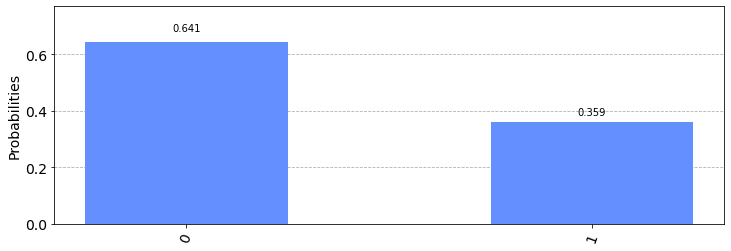

In [44]:
# Listing 14.2: Use the QBN for forward sampling
get_trained_qbn(train, trained_params)

In [45]:
## Section 14.2: Bayesian Rejection Sampling
def get_trained_qbn_norm(passengers, params):

    prepared_passengers = prepare_data(passengers, params)
    norm_params = calculate_norm_params(prepared_passengers)
    surv_params = calculate_surv_params(prepared_passengers)

    def qbn_titanic(): 
        def circuit(qc, qr=None, cr=None):
            apply_ischild_sex(qc)
            apply_norm(qc, norm_params)
            apply_class(qc)
            apply_survival(qc, surv_params)

            qc.measure(QPOS_ISCHILD, cr[0])
            qc.measure(QPOS_SEX, cr[1])
            qc.measure(QPOS_NORM, cr[2])

        return as_pqc(QUBITS, circuit, hist=False, cnt_classical=3, measure=True, shots=10000)
    return qbn_titanic()

In [46]:
# Listing 14.4: Obtain the measurements
norm_mes = get_trained_qbn_norm(train, trained_params)
norm_mes

{'000': 5333,
 '001': 331,
 '010': 31,
 '011': 10,
 '100': 736,
 '101': 75,
 '110': 3298,
 '111': 186}

In [47]:
# Listing 14.5: Calculate the conditional probabilities of being favored by a norm
print("Chance to be favored by norm")
print("Female children: {:.2f} ".format(norm_mes['111']/(norm_mes['111']+norm_mes['011'])))
print("Female adults: {:.2f} ".format(norm_mes['110']/(norm_mes['110']+norm_mes['010'])))
print("Male children: {:.2f} ".format(norm_mes['101']/(norm_mes['101']+norm_mes['001'])))
print("Male adults: {:.2f} ".format(norm_mes['100']/(norm_mes['100']+norm_mes['000'])))

Chance to be favored by norm
Female children: 0.95 
Female adults: 0.99 
Male children: 0.18 
Male adults: 0.12 


In [48]:
# Listing 14.6: Preparing the trained QBN to measure survival
def get_trained_qbn_surv(passengers, params):

    prepared_passengers = prepare_data(passengers, params)
    norm_params = calculate_norm_params(prepared_passengers)
    surv_params = calculate_surv_params(prepared_passengers)

    def qbn_titanic(): 
        def circuit(qc, qr=None, cr=None):
            apply_ischild_sex(qc)
            apply_norm(qc, norm_params)
            apply_class(qc)
            apply_survival(qc, surv_params)

            qc.measure(QPOS_NORM, cr[0])
            qc.measure(QPOS_FIRST, cr[1])
            qc.measure(QPOS_SECOND, cr[2])
            qc.measure(QPOS_THIRD, cr[3])
            qc.measure(QPOS_SURV, cr[4])

        return as_pqc(QUBITS, circuit, hist=False, cnt_classical=5, measure=True, shots=10000)
    return qbn_titanic()

In [49]:
# Listing 14.7: Obtain the measurements
surv_mes = get_trained_qbn_surv(train, trained_params)
surv_mes

{'10010': 339,
 '10011': 957,
 '10100': 79,
 '10101': 837,
 '11000': 247,
 '11001': 1289,
 '00010': 1071,
 '00011': 68,
 '00100': 1024,
 '00101': 80,
 '01000': 2948,
 '01001': 1061}

In [50]:
# Listing 14.8: Calculate the conditional probabilities of survival
print("Chance to survive")
print("Favored 1st: {:.2f} ".format(
    surv_mes['10011']/(surv_mes['10011']+surv_mes['00011'])))
print("Favored 2nd: {:.2f} ".format(
    surv_mes['10101']/(surv_mes['10101']+surv_mes['00101'])))
print("Favored 3rd: {:.2f} ".format(
    surv_mes['11001']/(surv_mes['11001']+surv_mes['01001'])))
print("Unfavored 1st: {:.2f} ".format(
    surv_mes['10010']/(surv_mes['10010']+surv_mes['00010'])))
print("Unfavored 2nd: {:.2f} ".format(
    surv_mes['10100']/(surv_mes['10100']+surv_mes['00100'])))
print("Unfavored 3rd: {:.2f} ".format(
    surv_mes['11000']/(surv_mes['11000']+surv_mes['01000'])))

Chance to survive
Favored 1st: 0.93 
Favored 2nd: 0.91 
Favored 3rd: 0.55 
Unfavored 1st: 0.24 
Unfavored 2nd: 0.07 
Unfavored 3rd: 0.08 


## Section 14.3: Quantum Rejection Sampling

In [51]:
# Listing 14.9: Evaluate the effectiveness
norm_mes = get_trained_qbn_norm(train, trained_params)
print("{:.2f} of female children were favored by a norm ".format(
    norm_mes['111']/(norm_mes['111']+norm_mes['011'])))
print("Considered {} samples ".format(
    norm_mes['111']+norm_mes['011']))
print ("Acceptance of {:.1f}% of the samples".format(
    (norm_mes['111']+norm_mes['011'])/100))

0.94 of female children were favored by a norm 
Considered 209 samples 
Acceptance of 2.1% of the samples


In [52]:
# Listing 14.10: The oracle‐function
def oracle(qr, draw=False):
    # Create a sub-circuit
    o_qc = QuantumCircuit(qr)

    o_qc.append(ZGate().control(2), [qr[QPOS_ISCHILD], qr[QPOS_SEX], qr[QPOS_NORM]])    
    
    if draw:
        return o_qc.draw()
    else:
        # We return the oracle as a gate
        Oracle = o_qc.to_gate()
        Oracle.name = "oracle"
        return Oracle

In [53]:
# Listing 14.11: The amplifier‐function
def amplifier(qr, draw=False):
    # Create a sub-circuit
    a_qc = QuantumCircuit(qr)

    apply_ischild_sex(a_qc) # H
    a_qc.x(qr[QPOS_ISCHILD])
    a_qc.x(qr[QPOS_SEX])
    a_qc.cz(qr[QPOS_ISCHILD], qr[QPOS_SEX])
    a_qc.x(qr[QPOS_ISCHILD])
    a_qc.x(qr[QPOS_SEX])
    apply_ischild_sex(a_qc) # H
    
    if draw:
        return a_qc.draw()
    else:
        # We return the oracle as a gate
        Amplifier = a_qc.to_gate()
        Amplifier.name = "amplifier"
        return Amplifier

In [55]:
# Listing 14.12: Prepare the amplified QBN
def get_trained_qbn_amp(passengers, params):

    prepared_passengers = prepare_data(passengers, params)
    norm_params = calculate_norm_params(prepared_passengers)
    surv_params = calculate_surv_params(prepared_passengers)

    def qbn_titanic(): 
        def circuit(qc, qr=None, cr=None):
        
            # amplifier replacing the H-gates
            qc.append(amplifier(qr), qr)

            # Amplification
            qc.append(oracle(qr), qr)
            qc.append(amplifier(qr), qr)
            qc.append(oracle(qr), qr)
            qc.append(amplifier(qr), qr)
            
            qc.x(QPOS_ISCHILD)
            qc.x(QPOS_SEX)
            apply_norm(qc, norm_params)
            apply_survival(qc, surv_params)
            
            qc.measure(QPOS_ISCHILD, cr[0])
            qc.measure(QPOS_SEX, cr[1])
            qc.measure(QPOS_NORM, cr[2])

        return as_pqc(QUBITS, circuit, hist=False, cnt_classical=3, measure=True, shots=10000)
    return qbn_titanic()

In [59]:
# Listing 14.13: Evaluate the effectiveness of the amplified QBN
amp_mes = get_trained_qbn_amp(train, trained_params)
print("{:.2f} of female children were favored by a norm ".format(
    amp_mes['111']/(amp_mes['111']+amp_mes['011'])))
print("Considered {} samples ".format(
    amp_mes['111']+amp_mes['011']))
print ("Acceptance of {:.1f}% of the samples".format(
    (amp_mes['111']+amp_mes['011'])/100))

0.94 of female children were favored by a norm 
Considered 9834 samples 
Acceptance of 98.3% of the samples
